# Setup

## Imports

In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dot
from tensorflow.keras.models import load_model
import sklearn
from sklearn.ensemble import StackingClassifier

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Concatenate, Dot, Lambda, Input, Dropout, Conv1D, Conv2D, GlobalAveragePooling2D, Average
from tensorflow.keras.optimizers import Adam

In [2]:
model1 = load_model('/content/drive/MyDrive/saved_models/vgg_model_new.h5',compile=False)
model2 = load_model('/content/drive/MyDrive/saved_models/resnet_model_new.h5',compile=False)
model3 = load_model('/content/drive/MyDrive/saved_models/efficientnet_model_new.h5',compile=False)

## Get average embeddings

### Training embeddings

In [3]:
base="/content/drive/MyDrive/dataset"
c=0
x=[]
y=[]
class_names = []
SIZE = 224
for folder in os.listdir(base):
  class_names.append(folder)
  for pic in os.listdir(base+"/"+folder):
    img=Image.open(base+"/"+folder+"/"+pic)
    img=img.resize((SIZE,SIZE))
    x+=[np.array(img)]
    y+=[c]
  c+=1   
X=np.array(x)
Y=np.array(y)

In [4]:
vgg_train_embeddings = []
resnet_train_embeddings = []
efficientnet_train_embeddings = []
for i in X:
  efficientnet_train_embeddings.append(model3.predict([np.expand_dims(i,axis=0)]))
  resnet_train_embeddings.append(model2.predict([np.expand_dims(i,axis=0)]))
  vgg_train_embeddings.append(model1.predict([np.expand_dims(i,axis=0)]))

In [5]:
table_data = []
for h,i,j,k in zip(Y, vgg_train_embeddings, resnet_train_embeddings, efficientnet_train_embeddings):
  m = [h,i[0], j[0], k[0]]
  table_data.append(m)

m = np.array(table_data,dtype=object)
print("data shape:",m.shape)

data shape: (88, 4)


In [6]:
old = list(range(len(class_names)))
df = pd.DataFrame(data = m, columns = ['class', 'vgg_embeddings', 'resnet_embeddings', 'efficientnet_embeddings'])
df['class'] = df['class'].replace(old,class_names)
df

,class,vgg_embeddings,resnet_embeddings,efficientnet_embeddings
0,drivers_license,"[1.6542804e-12, 0.00013831258, 1.556642e-05, 7...","[0.0020460188, 0.00039243698, 0.00021857023, 0...","[9.903545e-05, 0.00014334917, 2.9417079e-05, 3..."
1,drivers_license,"[3.7175866e-14, 5.2505743e-06, 8.1768476e-08, ...","[0.00047808886, 0.00021746755, 2.1552043e-05, ...","[9.253348e-05, 0.00033646822, 2.6838687e-05, 3..."
2,drivers_license,"[8.265591e-14, 1.03333805e-05, 3.024045e-07, 9...","[0.0016194582, 0.00034350157, 0.00010704375, 0...","[0.00013431907, 8.9341556e-05, 4.8190457e-05, ..."
3,drivers_license,"[2.7243536e-16, 1.5484948e-06, 3.2759397e-07, ...","[0.00068834424, 0.00031787157, 4.8014852e-05, ...","[0.00014716387, 8.043935e-05, 9.476029e-05, 4...."
4,drivers_license,"[2.5202378e-14, 1.0640482e-05, 2.5689272e-07, ...","[0.00023978949, 7.171741e-05, 7.034509e-05, 0....","[7.9000354e-05, 0.0003220141, 2.684954e-05, 3...."
...,...,...,...,...
83,old_voter_ID_card,"[4.457521e-11, 0.96047854, 0.9179219, 8.410088...","[0.00012024227, 0.000200212, 0.000860095, 0.00...","[0.00013425946, 2.8730043e-05, 0.00026217103, ..."
84,old_voter_ID_card,"[8.7428724e-13, 0.9581222, 0.8968253, 7.638389...","[0.00021854043, 0.0003208518, 0.00032675266, 0...","[8.790278e-05, 2.8699564e-05, 0.00027534366, 0..."
85,old_voter_ID_card,"[2.110616e-13, 0.978493, 0.8549284, 2.2445015e...","[0.00035902858, 0.00036469102, 0.0006608367, 0...","[7.169532e-05, 4.7297686e-05, 0.0001746118, 0...."
86,old_voter_ID_card,"[6.149229e-14, 0.9850162, 0.95042026, 4.229826...","[0.0003450215, 0.00034037232, 0.00082299113, 0...","[0.00011999896, 2.1315951e-05, 0.0003912151, 0..."


In [7]:
df.to_json('embeddings.json',orient='records')

### average training embeddings

In [8]:
a = df.groupby(['class'])
avg_data=pd.concat([a.vgg_embeddings.apply(np.mean),a.resnet_embeddings.apply(np.mean),a.efficientnet_embeddings.apply(np.mean)],axis=1)
avg_data['class_name']=sorted(class_names)

In [9]:
avg_data

,vgg_embeddings,resnet_embeddings,efficientnet_embeddings,class_name
class,,,,
MSRIT_ID_card,"[7.018993e-10, 0.0034917241, 0.002007663, 7.89...","[0.00012283151, 0.00021009012, 0.0019864195, 0...","[5.4894794e-05, 9.294538e-05, 3.2979435e-05, 0...",MSRIT_ID_card
aadhar_card_bottom,"[1.1816828e-11, 2.1638984e-06, 3.056744e-07, 0...","[0.00022486536, 0.00018578362, 1.6517033e-05, ...","[4.9858532e-05, 0.0003565089, 3.726676e-05, 8....",aadhar_card_bottom
aadhar_card_full,"[7.72868e-12, 0.00014532215, 1.3582693e-05, 4....","[0.0009613823, 0.00014528679, 0.00036223096, 0...","[0.0008766191, 3.9321545e-05, 0.00033641674, 6...",aadhar_card_full
drivers_license,"[1.3234572e-11, 0.00016695305, 3.7843042e-06, ...","[0.0008569414, 0.00020916462, 0.00014607728, 0...","[0.00011095759, 0.00018027806, 5.1342988e-05, ...",drivers_license
new_voter_ID_card,"[2.2359236e-13, 2.7068412e-05, 4.5679426e-06, ...","[7.3387244e-05, 0.00022618879, 0.00018499893, ...","[6.1832376e-05, 9.7536686e-05, 0.00013507597, ...",new_voter_ID_card
old_voter_ID_card,"[7.5040016e-11, 0.9712961, 0.92608225, 3.34901...","[0.00019831727, 0.0002923689, 0.0010397732, 0....","[0.00014459716, 2.6903666e-05, 0.00036137755, ...",old_voter_ID_card
pan_card,"[5.330417e-10, 1.3936722e-05, 4.9572507e-05, 7...","[0.0002310688, 0.00012608772, 4.3940465e-05, 0...","[8.686146e-05, 0.0001267846, 4.211739e-05, 0.0...",pan_card
passport,"[4.4280577e-12, 0.0004669575, 0.07559161, 7.18...","[0.0001271441, 0.00021842663, 1.7418437e-05, 9...","[0.00014537323, 3.861016e-05, 0.00023620106, 5...",passport


In [10]:
df.to_json('avg_embeddings.json',orient='records')

In [11]:
class_names = sorted(class_names)

# Testing

## Helper functions

In [12]:
def cosine_similarity(vects):
  x, y = vects
  dotxy = Dot(axes=1)([x, y])
  magx  = K.sqrt(Dot(axes=1)([x,x]))
  magy  = K.sqrt(Dot(axes=1)([y,y]))
  return (dotxy/(magx*magy))

In [13]:
def predict(x,avg_data):
  vpred = []
  rpred = []
  epred = []
  v = model1.predict([np.expand_dims(x,axis=0)])
  r = model2.predict([np.expand_dims(x,axis=0)])
  e = model3.predict([np.expand_dims(x,axis=0)])
  for i in avg_data.values:
    vpred.append(cosine_similarity([tf.constant(v),tf.constant(np.expand_dims(i[0], axis=0))]).numpy()[0][0])
    rpred.append(cosine_similarity([tf.constant(r),tf.constant(np.expand_dims(i[1], axis=0))]).numpy()[0][0])
    epred.append(cosine_similarity([tf.constant(e),tf.constant(np.expand_dims(i[2], axis=0))]).numpy()[0][0])
  avg = np.average(np.array([vpred,rpred,epred]),axis=0)
  avg = avg.tolist()
  max_val = max(avg)
  a = avg.index(max_val)
  max_class = class_names[a]
  return [max_val,max_class, avg]

## Test dataset results 

### With existing embeddings in repository

In [14]:
base="/content/drive/MyDrive/dataset_test"
mi = 1
for folder in os.listdir(base):
  for pic in os.listdir(base+"/"+folder):
    img=Image.open(base+"/"+folder+"/"+pic)
    img=img.resize((SIZE,SIZE))
    x = np.array(img)
    [max_val, max_class, avg] = predict(x,avg_data)
    print(pic," : ",max_class,"-",max_val)
    if max_val<mi:
      mi = max_val
print("minimum value:",mi)

aadt1.jpg  :  aadhar_card_full - 0.9997227191925049
aadt2.jpg  :  aadhar_card_full - 0.9950895309448242
aadt3.jpg  :  aadhar_card_full - 0.9995532035827637
aadt4.jpg  :  aadhar_card_full - 0.9998238682746887
aadt5.jpg  :  aadhar_card_full - 0.9989334940910339
aadbt1.jpg  :  aadhar_card_bottom - 0.9969502091407776
aadbt2.jpg  :  aadhar_card_bottom - 0.9949076771736145
aadbt4.jpg  :  aadhar_card_bottom - 0.9669305682182312
aadbt5.jpg  :  aadhar_card_bottom - 0.9876692891120911
aadbt3.jpg  :  aadhar_card_bottom - 0.9783570170402527
idt1.jpg  :  MSRIT_ID_card - 0.9402119517326355
idt2.jpg  :  MSRIT_ID_card - 0.9939311146736145
idt3.jpg  :  MSRIT_ID_card - 0.9904699921607971
idt4.jpg  :  MSRIT_ID_card - 0.9527381062507629
idt5.jpg  :  MSRIT_ID_card - 0.9520047307014465
passt2.jpg  :  passport - 0.9875979423522949
passt3.jpg  :  passport - 0.98844975233078
passt4.jpg  :  passport - 0.9739205241203308
passt1.jpg  :  passport - 0.9776961207389832
passt5.jpg  :  passport - 0.994030237197876
pan

These are unknown images that haven't been seen before:

In [15]:
base="/content/drive/MyDrive/form_data/unknown"
for pic in os.listdir(base):
  img=Image.open(base+"/"+pic)
  img=img.resize((SIZE,SIZE))
  x = np.array(img)
  [max_val, max_class, avg] = predict(x,avg_data)
  print(pic," : ",max_class,"-",max_val)

aakashID.jpg  :  drivers_license - 0.5271331071853638
Kaagaz_1.jpg  :  drivers_license - 0.6935107111930847
Kaagaz_2.jpg  :  drivers_license - 0.7528157830238342
Kaagaz_3.jpg  :  drivers_license - 0.8266250491142273
ranpass.jpg  :  passport - 0.9874081015586853


### After adding one sample from unknown class into the repository

In [16]:
i=Image.open("/content/drive/MyDrive/form_data/unknown/Kaagaz_1.jpg")
i=i.resize((SIZE,SIZE))
i = np.array(i)
row = [
model1.predict([np.expand_dims(i,axis=0)])[0],
model2.predict([np.expand_dims(i,axis=0)])[0],
model3.predict([np.expand_dims(i,axis=0)])[0],
"hall_ticket"]

In [17]:
t = pd.DataFrame([row],columns=["vgg_embeddings",	"resnet_embeddings", "efficientnet_embeddings",	"class_name"])
avg_data1 = avg_data.append(t, ignore_index=True)
class_names.append("hall_ticket")
avg_data1

,vgg_embeddings,resnet_embeddings,efficientnet_embeddings,class_name
0,"[7.018993e-10, 0.0034917241, 0.002007663, 7.89...","[0.00012283151, 0.00021009012, 0.0019864195, 0...","[5.4894794e-05, 9.294538e-05, 3.2979435e-05, 0...",MSRIT_ID_card
1,"[1.1816828e-11, 2.1638984e-06, 3.056744e-07, 0...","[0.00022486536, 0.00018578362, 1.6517033e-05, ...","[4.9858532e-05, 0.0003565089, 3.726676e-05, 8....",aadhar_card_bottom
2,"[7.72868e-12, 0.00014532215, 1.3582693e-05, 4....","[0.0009613823, 0.00014528679, 0.00036223096, 0...","[0.0008766191, 3.9321545e-05, 0.00033641674, 6...",aadhar_card_full
3,"[1.3234572e-11, 0.00016695305, 3.7843042e-06, ...","[0.0008569414, 0.00020916462, 0.00014607728, 0...","[0.00011095759, 0.00018027806, 5.1342988e-05, ...",drivers_license
4,"[2.2359236e-13, 2.7068412e-05, 4.5679426e-06, ...","[7.3387244e-05, 0.00022618879, 0.00018499893, ...","[6.1832376e-05, 9.7536686e-05, 0.00013507597, ...",new_voter_ID_card
5,"[7.5040016e-11, 0.9712961, 0.92608225, 3.34901...","[0.00019831727, 0.0002923689, 0.0010397732, 0....","[0.00014459716, 2.6903666e-05, 0.00036137755, ...",old_voter_ID_card
6,"[5.330417e-10, 1.3936722e-05, 4.9572507e-05, 7...","[0.0002310688, 0.00012608772, 4.3940465e-05, 0...","[8.686146e-05, 0.0001267846, 4.211739e-05, 0.0...",pan_card
7,"[4.4280577e-12, 0.0004669575, 0.07559161, 7.18...","[0.0001271441, 0.00021842663, 1.7418437e-05, 9...","[0.00014537323, 3.861016e-05, 0.00023620106, 5...",passport
8,"[1.7521384e-11, 0.02437079, 0.0065698028, 5.58...","[0.00020116568, 0.00012233084, 0.00010247066, ...","[0.0003271699, 4.2571144e-05, 0.00045078993, 0...",hall_ticket


In [18]:
base="/content/drive/MyDrive/form_data/unknown"
for pic in os.listdir(base):
  img=Image.open(base+"/"+pic)
  img=img.resize((SIZE,SIZE))
  x = np.array(img)
  [max_val, max_class, aa] = predict(x,avg_data1)
  print(pic," : ",max_class,"-",max_val)

aakashID.jpg  :  drivers_license - 0.5271331071853638
Kaagaz_1.jpg  :  hall_ticket - 1.0
Kaagaz_2.jpg  :  hall_ticket - 0.8590190410614014
Kaagaz_3.jpg  :  hall_ticket - 0.8878737092018127
ranpass.jpg  :  passport - 0.9874081015586853


# individual models

## Images from known and unknown class

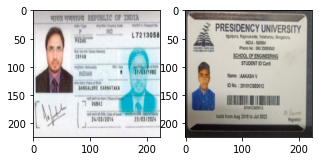

In [19]:
pic1 = Image.open("/content/drive/MyDrive/form_data/unknown/ranpass.jpg",mode="r")
pic2 = Image.open("/content/drive/MyDrive/form_data/unknown/aakashID.jpg",mode="r")
pic1=pic1.resize((224,224))
pic2=pic2.resize((224,224))
f, ax = plt.subplots(1,2,figsize=(5, 5))
ax[0].imshow(pic1)
ax[1].imshow(pic2)

In [20]:
def getpreds(model,pic1,pic2,n):
    img1=np.array(pic1)
    emb1=model.predict([np.expand_dims(img1,axis=0)])
    img2=np.array(pic2)
    emb2=model.predict([np.expand_dims(img2,axis=0)])
    preds1 = []
    preds2 = []
    for i in range(len(avg_data)):
        a = tf.constant(np.expand_dims(avg_data.iloc[i,n],axis=0))
        preds1.append(cosine_similarity([a,tf.constant(emb1)]).numpy()[0][0])
        preds2.append(cosine_similarity([a,tf.constant(emb2)]).numpy()[0][0])
    preds1 = np.array(preds1)
    preds1 = np.expand_dims(preds1,axis=0)
    preds2 = np.array(preds2)
    preds2 = np.expand_dims(preds2,axis=0)
    return (preds1,preds2)

In [21]:
(preds11,preds12) = getpreds(model1,pic1,pic2,0)
(preds21,preds22) = getpreds(model2,pic1,pic2,1)
(preds31,preds32) = getpreds(model3,pic1,pic2,2)

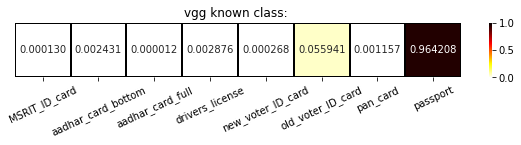

In [22]:
f, ax = plt.subplots(figsize=(10, 1))
a = max(preds11[0])
ax.set(title='vgg known class: ')
ax = sns.heatmap(preds11,cmap="hot_r",xticklabels=class_names[:-1],yticklabels=False, vmin=0, vmax=1, annot=True, fmt="f",linewidths=1,linecolor="black")
for item in ax.get_xticklabels():
    item.set_rotation(25)

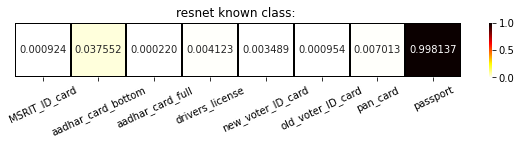

In [23]:
f, ax = plt.subplots(figsize=(10, 1))
a = max(preds21[0])
ax.set(title='resnet known class: ')
ax = sns.heatmap(preds21,cmap="hot_r",xticklabels=class_names[:-1],yticklabels=False, vmin=0, vmax=1, annot=True, fmt="f",linewidths=1,linecolor="black")
for item in ax.get_xticklabels():
    item.set_rotation(25)

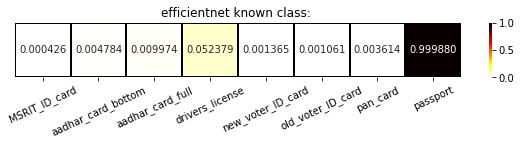

In [24]:
f, ax = plt.subplots(figsize=(10, 1))
a = max(preds31[0])
ax.set(title='efficientnet known class: ')
ax = sns.heatmap(preds31,cmap="hot_r",xticklabels=class_names[:-1],yticklabels=False, vmin=0, vmax=1, annot=True, fmt="f",linewidths=1,linecolor="black")
for item in ax.get_xticklabels():
    item.set_rotation(25)

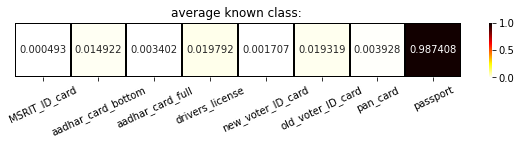

In [25]:
avg = np.average(np.array([preds11,preds21,preds31]),axis=0)
f, ax = plt.subplots(figsize=(10, 1))
a = max(avg[0])
ax.set(title='average known class: ')
ax = sns.heatmap(avg,cmap="hot_r",xticklabels=class_names[:-1],yticklabels=False, vmin=0, vmax=1, annot=True, fmt="f",linewidths=1,linecolor="black")
for item in ax.get_xticklabels():
    item.set_rotation(25)

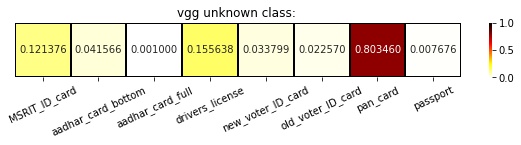

In [26]:
f, ax = plt.subplots(figsize=(10, 1))
a = max(preds12[0])
ax.set(title='vgg unknown class: ')
ax = sns.heatmap(preds12,cmap="hot_r",xticklabels=class_names[:-1],yticklabels=False, vmin=0, vmax=1, annot=True, fmt="f",linewidths=1,linecolor="black")
for item in ax.get_xticklabels():
    item.set_rotation(25)

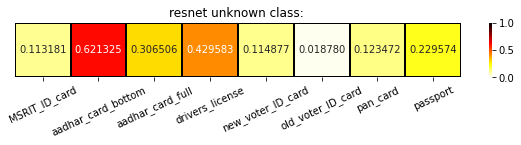

In [27]:
f, ax = plt.subplots(figsize=(10, 1))
a = max(preds22[0])
ax.set(title='resnet unknown class: ')
ax = sns.heatmap(preds22,cmap="hot_r",xticklabels=class_names[:-1],yticklabels=False, vmin=0, vmax=1, annot=True, fmt="f",linewidths=1,linecolor="black")
for item in ax.get_xticklabels():
    item.set_rotation(25)

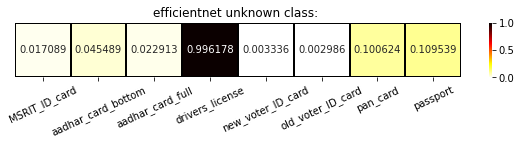

In [28]:
f, ax = plt.subplots(figsize=(10, 1))
a = max(preds32[0])
ax.set(title='efficientnet unknown class: ')
ax = sns.heatmap(preds32,cmap="hot_r",xticklabels=class_names[:-1],yticklabels=False, vmin=0, vmax=1, annot=True, fmt="f",linewidths=1,linecolor="black")
for item in ax.get_xticklabels():
    item.set_rotation(25)

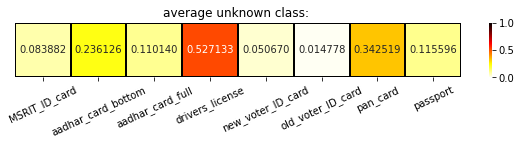

In [29]:
avg = np.average(np.array([preds12,preds22,preds32]),axis=0)
f, ax = plt.subplots(figsize=(10, 1))
a = max(avg[0])
ax.set(title='average unknown class: ')
ax = sns.heatmap(avg,cmap="hot_r",xticklabels=class_names[:-1],yticklabels=False, vmin=0, vmax=1, annot=True, fmt="f",linewidths=1,linecolor="black")
for item in ax.get_xticklabels():
    item.set_rotation(25)

## Images from same unknown class

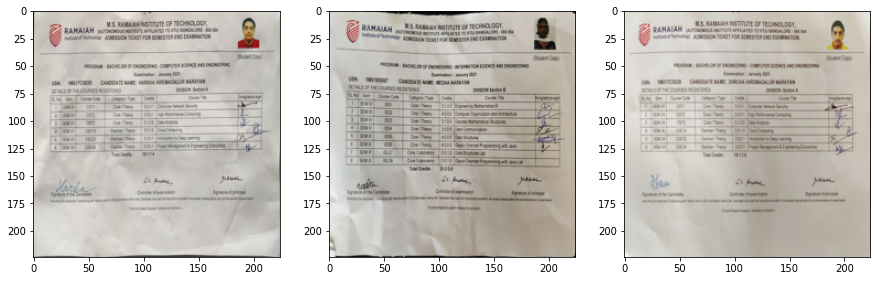

In [30]:
pic1 = Image.open("/content/drive/MyDrive/form_data/unknown/Kaagaz_1.jpg",mode="r")
pic2 = Image.open("/content/drive/MyDrive/form_data/unknown/Kaagaz_2.jpg",mode="r")
pic3 = Image.open("/content/drive/MyDrive/form_data/unknown/Kaagaz_3.jpg",mode="r")
pic1=pic1.resize((224,224))
pic2=pic2.resize((224,224))
pic3=pic3.resize((224,224))
f, ax = plt.subplots(1,3,figsize=(15, 5))
ax[0].imshow(pic1)
ax[1].imshow(pic2)
ax[2].imshow(pic3)

In [31]:
#vgg result
emb1=model1.predict([np.expand_dims(pic1,axis=0)])
emb2=model1.predict([np.expand_dims(pic2,axis=0)])
emb3=model1.predict([np.expand_dims(pic3,axis=0)])

print("similarity of hall tickets according to vgg model")
print("1&2:",cosine_similarity([tf.constant(emb1),tf.constant(emb2)]).numpy()[0][0])
print("1&3:",cosine_similarity([tf.constant(emb1),tf.constant(emb3)]).numpy()[0][0])
print("2&3:",cosine_similarity([tf.constant(emb2),tf.constant(emb3)]).numpy()[0][0])

similarity of hall tickets according to vgg model
1&2: 0.8150327
1&3: 0.7010069
2&3: 0.8799392


In [32]:
#resnet result
emb1=model2.predict([np.expand_dims(pic1,axis=0)])
emb2=model2.predict([np.expand_dims(pic2,axis=0)])
emb3=model2.predict([np.expand_dims(pic3,axis=0)])

print("similarity of hall tickets according to resnet model")
print("1&2:",cosine_similarity([tf.constant(emb1),tf.constant(emb2)]).numpy()[0][0])
print("1&3:",cosine_similarity([tf.constant(emb1),tf.constant(emb3)]).numpy()[0][0])
print("2&3:",cosine_similarity([tf.constant(emb2),tf.constant(emb3)]).numpy()[0][0])

similarity of hall tickets according to resnet model
1&2: 0.85641253
1&3: 0.9823183
2&3: 0.74631494


In [33]:
#effnet result
emb1=model3.predict([np.expand_dims(pic1,axis=0)])
emb2=model3.predict([np.expand_dims(pic2,axis=0)])
emb3=model3.predict([np.expand_dims(pic3,axis=0)])

print("similarity of hall tickets according to efficientnet model")
print("1&2:",cosine_similarity([tf.constant(emb1),tf.constant(emb2)]).numpy()[0][0])
print("1&3:",cosine_similarity([tf.constant(emb1),tf.constant(emb3)]).numpy()[0][0])
print("2&3:",cosine_similarity([tf.constant(emb2),tf.constant(emb3)]).numpy()[0][0])

similarity of hall tickets according to efficientnet model
1&2: 0.9056119
1&3: 0.98029596
2&3: 0.9477394
